In [1]:
import matplotlib.pyplot as plt
import numpy as np

<h3>Define the functions of create raw data </h3>

In [2]:
def generate_linear(n=100):
    pts=np.random.uniform(0,1,(n,2))
    inputs=[]
    labels=[]
    for pt in pts:
        inputs.append([pt[0],pt[1]])
        distance=(pt[0]-pt[1])/1.414
        if pt[0]>pt[1]:
            labels.append(0)
        else:
            labels.append(1)

    return np.array(inputs),np.array(labels).reshape(n,1)


def generate_XOR_easy():
    inputs=[]
    labels=[]
    for i in range(11):
        inputs.append([0.1*i,0.1*i])
        labels.append(0)
        if 0.1*i==0.5:
            continue
            
        inputs.append([0.1*i,1-0.1*i])
        labels.append(1)
    
    return np.array(inputs),np.array(labels).reshape(21,1)

<h3>Draw result of predict and ground truth</h3>

In [3]:
def show_result(x,y,pred_y):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.title('Ground truth',fontsize=18)
    for i in range(x.shape[0]):
        if y[i]==0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
        
    plt.subplot(1,2,2)
    plt.title('Predict result',fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i]<0.5:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')            
    
#     plt.savefig('./image.jpg',dpi=300)
    plt.show()

<h3>Initialize neural network</h3>

In [4]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

<h3>Define the functions of activation</h3>

In [5]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def NONE(Z):
    return np.array(Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

def NONE_backward(dA,Z):
    return np.array(Z)

<h3>Define the functions of forward propagation</h3>

In [6]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    elif activation is "None":
        activation_func = NONE
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

<h3>Define the functions to calculate the loss</h3>

In [7]:
# Binary crossentropy

def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

<h3>Define the functions of convert probability into class and calculate accuracy </h3>

In [8]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

<h3>Define the functions of backward propagation</h3>

In [9]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    elif activation is "None":
        backward_activation_func = NONE_backward
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}

    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

<h3>Define functions of optimizer</h3>

In [10]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

<h3>Functions of training</h3>

In [11]:
def train(X, Y, nn_architecture, epochs, learning_rate):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            print("epoch: {:05} - loss: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if cost<0.1:
                break
            
    return params_values,cost_history,accuracy_history

In [12]:
#Define network

nn_architecture = [
    {"input_dim": 2, "output_dim": 5, "activation": "relu"},
    {"input_dim": 5, "output_dim": 10, "activation": "relu"},
    {"input_dim": 10, "output_dim": 1, "activation": "sigmoid"},
]

<h3>Linear data</h3>

In [13]:
#Create data

x,y=generate_linear(n=100)

In [14]:
#Training

params_values,cost_history,accuracy_history = train(np.transpose(x), np.transpose(y), nn_architecture, 2000,0.1)

epoch: 00000 - loss: 0.70050 - accuracy: 0.47000
epoch: 00050 - loss: 0.69086 - accuracy: 0.53000
epoch: 00100 - loss: 0.68931 - accuracy: 0.53000
epoch: 00150 - loss: 0.68757 - accuracy: 0.53000
epoch: 00200 - loss: 0.68428 - accuracy: 0.53000
epoch: 00250 - loss: 0.67724 - accuracy: 0.53000
epoch: 00300 - loss: 0.65941 - accuracy: 0.53000
epoch: 00350 - loss: 0.60777 - accuracy: 0.74000
epoch: 00400 - loss: 0.48638 - accuracy: 0.83000
epoch: 00450 - loss: 0.33169 - accuracy: 0.93000
epoch: 00500 - loss: 0.21904 - accuracy: 0.97000
epoch: 00550 - loss: 0.15688 - accuracy: 0.97000
epoch: 00600 - loss: 0.12097 - accuracy: 0.99000
epoch: 00650 - loss: 0.09831 - accuracy: 1.00000


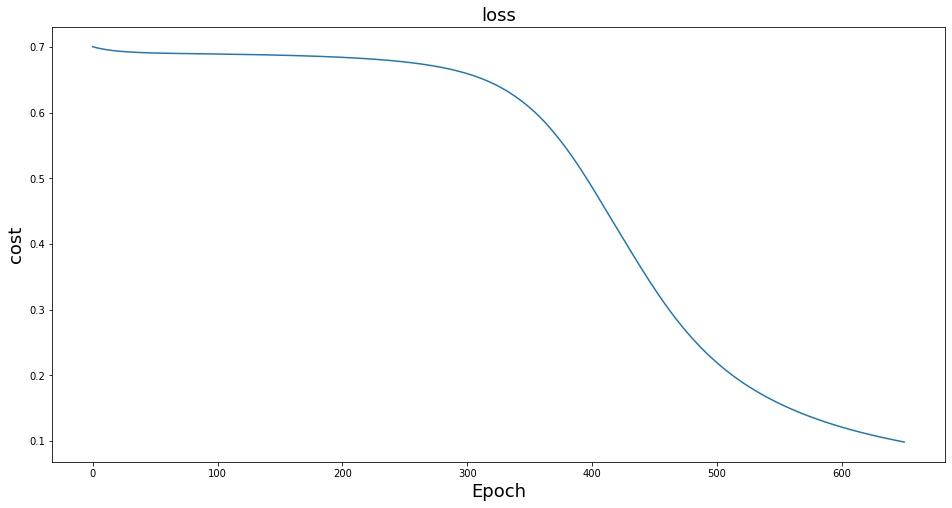

In [15]:
#Draw loss

plt.figure(figsize=(16,8))
plt.title('loss',fontsize=18)
plt.ylabel("cost",fontsize=18)
plt.xlabel("Epoch",fontsize=18) 
plt.plot(range(len(cost_history)),cost_history)
plt.show()

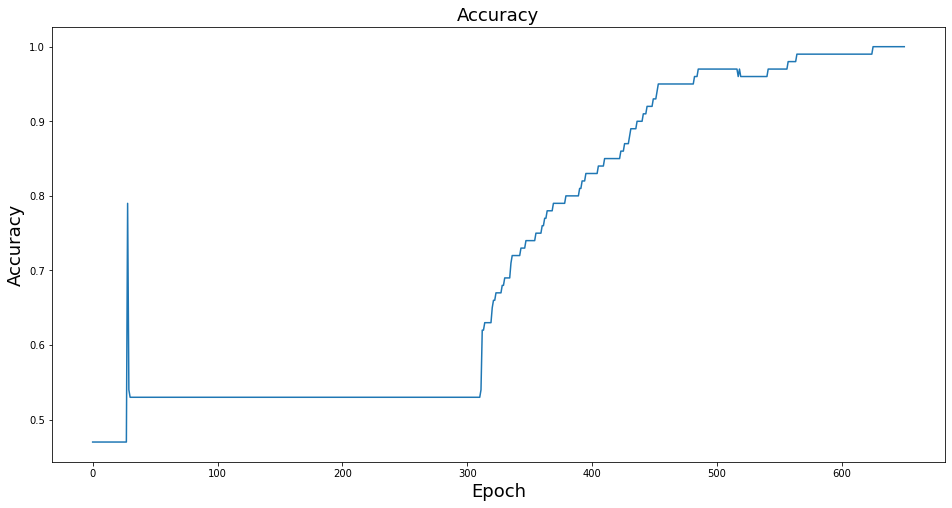

In [16]:
#Draw accuracy

plt.figure(figsize=(16,8))
plt.title('Accuracy',fontsize=18)
plt.ylabel("Accuracy",fontsize=18)
plt.xlabel("Epoch",fontsize=18) 
plt.plot(range(len(accuracy_history)),accuracy_history)
plt.show()

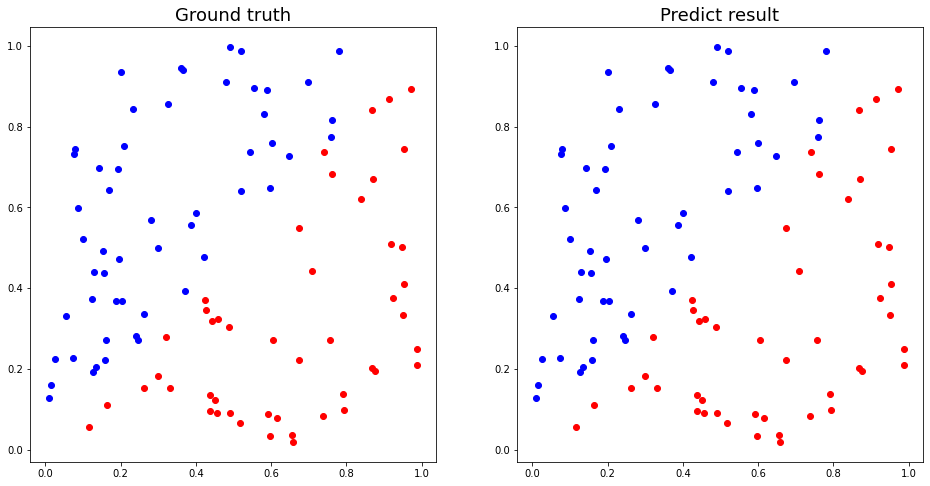

In [17]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(x), params_values, nn_architecture)
show_result(x, y, Y_test_hat.reshape(-1,1))

In [18]:
Y_test_hat

array([[0.91500299, 0.83936145, 0.39229974, 0.01291641, 0.01574992,
        0.18115717, 0.84803288, 0.96106892, 0.01714685, 0.11019754,
        0.01507689, 0.99998748, 0.9996716 , 0.50521578, 0.41099026,
        0.82805076, 0.83386326, 0.99976868, 0.01426218, 0.95412472,
        0.99407165, 0.01896671, 0.96039665, 0.99986065, 0.01641249,
        0.01167914, 0.06402604, 0.96784894, 0.01985934, 0.01502249,
        0.13222394, 0.99793302, 0.01650528, 0.01136582, 0.96335868,
        0.99988429, 0.01352525, 0.99669507, 0.9998256 , 0.97019356,
        0.99955993, 0.01372455, 0.99989848, 0.99931714, 0.05045752,
        0.33246052, 0.01532854, 0.99981207, 0.02537098, 0.999969  ,
        0.75130135, 0.01851857, 0.0213269 , 0.99362563, 0.93596479,
        0.99974316, 0.19497096, 0.14503052, 0.88920645, 0.99991045,
        0.99343   , 0.02084514, 0.23801183, 0.66137516, 0.16743282,
        0.02026591, 0.01688938, 0.93117465, 0.77458252, 0.97501073,
        0.69759922, 0.96560132, 0.99673196, 0.01

In [19]:
# Accuracy
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y))
print("Test set accuracy: {:.2f} ".format(acc_test))

Test set accuracy: 1.00 


<h3>XOR data</h3>

In [20]:
#Create data

x,y=generate_XOR_easy()

In [21]:
#Training

params_values,cost_history,accuracy_history = train(np.transpose(x), np.transpose(y), nn_architecture, 2000,0.1)

epoch: 00000 - loss: 0.69231 - accuracy: 0.52381
epoch: 00050 - loss: 0.69190 - accuracy: 0.52381
epoch: 00100 - loss: 0.69184 - accuracy: 0.52381
epoch: 00150 - loss: 0.69180 - accuracy: 0.52381
epoch: 00200 - loss: 0.69175 - accuracy: 0.52381
epoch: 00250 - loss: 0.69168 - accuracy: 0.52381
epoch: 00300 - loss: 0.69157 - accuracy: 0.52381
epoch: 00350 - loss: 0.69145 - accuracy: 0.52381
epoch: 00400 - loss: 0.69134 - accuracy: 0.52381
epoch: 00450 - loss: 0.69121 - accuracy: 0.52381
epoch: 00500 - loss: 0.69104 - accuracy: 0.52381
epoch: 00550 - loss: 0.69084 - accuracy: 0.52381
epoch: 00600 - loss: 0.69058 - accuracy: 0.52381
epoch: 00650 - loss: 0.69027 - accuracy: 0.52381
epoch: 00700 - loss: 0.68988 - accuracy: 0.52381
epoch: 00750 - loss: 0.68940 - accuracy: 0.52381
epoch: 00800 - loss: 0.68876 - accuracy: 0.52381
epoch: 00850 - loss: 0.68793 - accuracy: 0.52381
epoch: 00900 - loss: 0.68682 - accuracy: 0.52381
epoch: 00950 - loss: 0.68529 - accuracy: 0.52381
epoch: 01000 - loss:

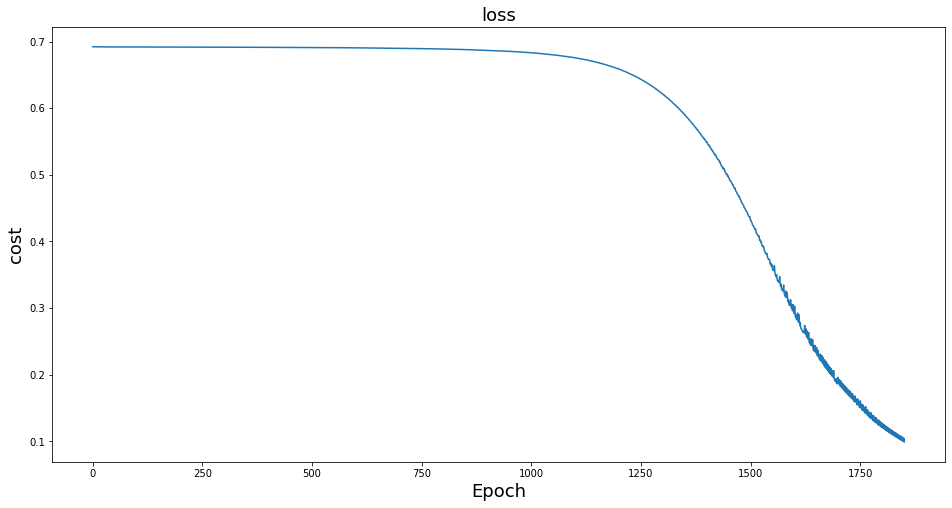

In [22]:
#Draw loss

plt.figure(figsize=(16,8))
plt.title('loss',fontsize=18)
plt.ylabel("cost",fontsize=18)
plt.xlabel("Epoch",fontsize=18) 
plt.plot(range(len(cost_history)),cost_history)
plt.show()

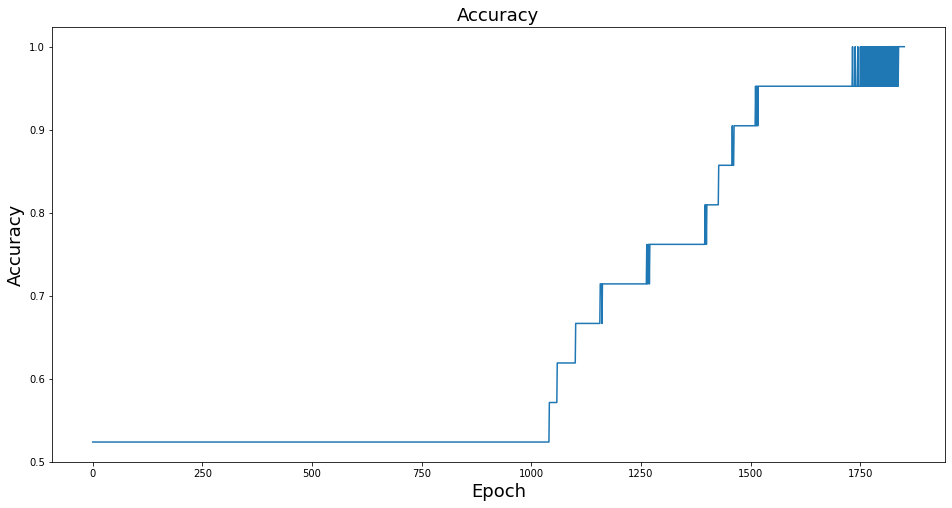

In [23]:
#Draw accuracy

plt.figure(figsize=(16,8))
plt.title('Accuracy',fontsize=18)
plt.ylabel("Accuracy",fontsize=18)
plt.xlabel("Epoch",fontsize=18) 
plt.plot(range(len(accuracy_history)),accuracy_history)
plt.show()

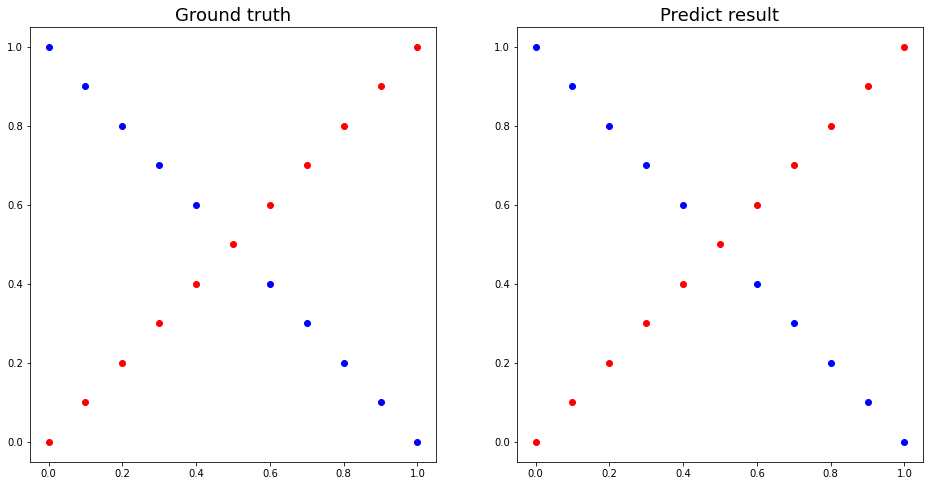

In [24]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(x), params_values, nn_architecture)
show_result(x, y, Y_test_hat.reshape(-1,1))

In [25]:
Y_test_hat

array([[0.00558772, 0.99867935, 0.01012527, 0.99466112, 0.01830232,
        0.97867797, 0.03285863, 0.88443008, 0.06147493, 0.51034213,
        0.12630276, 0.12914998, 0.86757556, 0.13205168, 0.96338452,
        0.13513715, 0.96338452, 0.13880212, 0.96338452, 0.1425501 ,
        0.96338452]])

In [26]:
# Accuracy
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y))
print("Test set accuracy: {:.2f} ".format(acc_test))

Test set accuracy: 1.00 


<h3>Reference : https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb</h3>